***Importation des Libraires***


In [80]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,f1_score, roc_auc_score,recall_score, precision_score
from sklearn.model_selection import train_test_split
import xgboost as xgb
import lightgbm as lgb
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import cross_val_score
import joblib

***1-Exploration et Analyse des Données (EAD)***


1. Analyse des colonnes et distribution des classes

In [81]:
train_data = pd.read_csv('train.En.csv')
train_data.info()
train_data.head()
train_data.describe()
counts =train_data['sarcastic'].value_counts()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3468 entries, 0 to 3467
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           3468 non-null   int64  
 1   tweet                3467 non-null   object 
 2   sarcastic            3468 non-null   int64  
 3   rephrase             867 non-null    object 
 4   sarcasm              867 non-null    float64
 5   irony                867 non-null    float64
 6   satire               867 non-null    float64
 7   understatement       867 non-null    float64
 8   overstatement        867 non-null    float64
 9   rhetorical_question  867 non-null    float64
dtypes: float64(6), int64(2), object(2)
memory usage: 271.1+ KB


2. Mesure de la longueur des textes

In [82]:
train_data['word_count'] = train_data['tweet'].apply(lambda x: len(str(x).split()))
train_data['char_count'] = train_data['tweet'].apply(lambda x: len(str(x)))


3. Visualisation des données

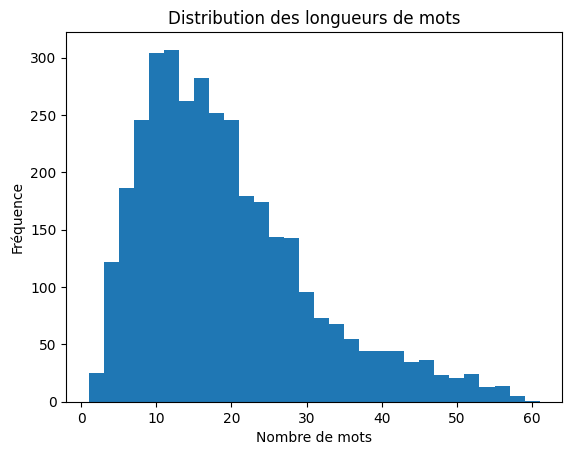

In [83]:
plt.hist(train_data['word_count'], bins=30)
plt.title('Distribution des longueurs de mots')
plt.xlabel('Nombre de mots')
plt.ylabel('Fréquence')
plt.show()

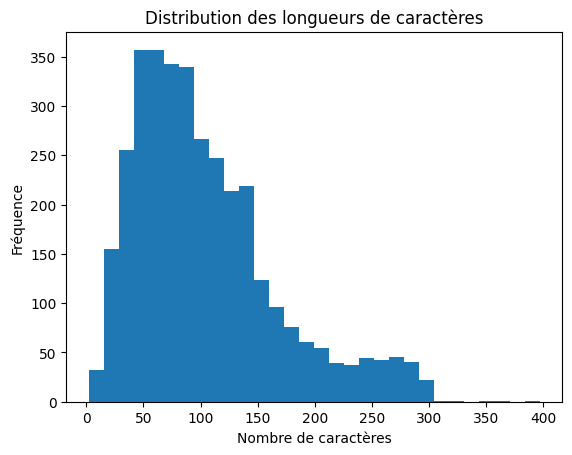

In [84]:
plt.hist(train_data['char_count'], bins=30)
plt.title('Distribution des longueurs de caractères')
plt.xlabel('Nombre de caractères')
plt.ylabel('Fréquence')
plt.show()

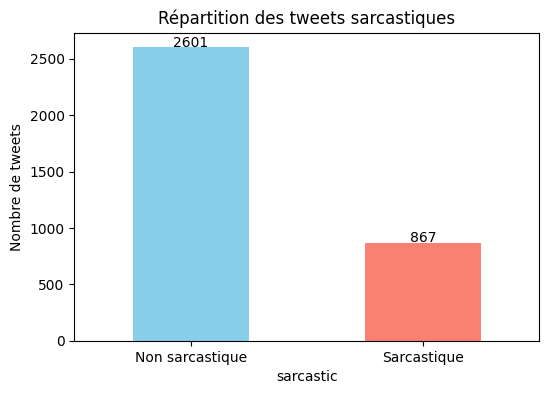

In [85]:
plt.figure(figsize=(6,4))
counts.plot(kind='bar', color=['skyblue','salmon'])
plt.xticks([0,1], ['Non sarcastique', 'Sarcastique'], rotation=0)
plt.title("Répartition des tweets sarcastiques")
plt.ylabel("Nombre de tweets")
for i, v in enumerate(counts.values):
    plt.text(i, v + 5, str(v), ha='center')
plt.show()

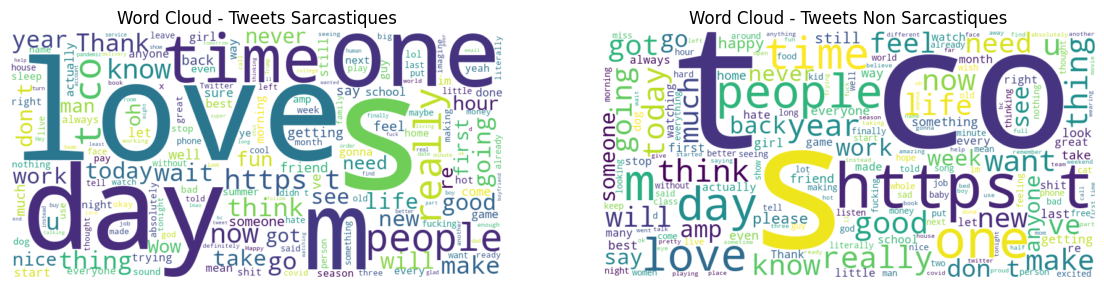

In [86]:
tweets_sarcastic = ' '.join(train_data[train_data['sarcastic'] == 1]['tweet'].astype(str))
tweets_non_sarcastic = ' '.join(train_data[train_data['sarcastic'] == 0]['tweet'].astype(str))
stopwords=set(STOPWORDS)
wordcloud_sarcastic = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords).generate(tweets_sarcastic)
wordcloud_non_sarcastic = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords).generate(tweets_non_sarcastic)
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_sarcastic, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Tweets Sarcastiques')
plt.subplot(1, 2, 2)
plt.imshow(wordcloud_non_sarcastic, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Tweets Non Sarcastiques')
plt.show()



***2-Prétraitement du texte***

In [87]:
train_data=train_data[["tweet","sarcastic"]]
train_data.head()

,tweet,sarcastic
0,The only thing I got from college is a caffein...,1
1,I love it when professors draw a big question ...,1
2,Remember the hundred emails from companies whe...,1
3,Today my pop-pop told me I was not “forced” to...,1
4,@VolphanCarol @littlewhitty @mysticalmanatee I...,1


1. Nettoyage et transformation du texte

In [88]:
def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text)       
    text = re.sub(r"@\w+", "", text)                 
    text = re.sub(r"#", "", text)                    
    text = re.sub(r"[^a-zA-Z\s]", "", text)          
    text = re.sub(r"\s+", " ", text).strip()
    words = [word for word in text.split() if word not in stopwords]
    text = " ".join(words)

    return text


In [89]:
train_data['text_cleaned'] = train_data['tweet'].apply(clean_text)
train_data.head()

,tweet,sarcastic,text_cleaned
0,The only thing I got from college is a caffein...,1,thing got college caffeine addiction
1,I love it when professors draw a big question ...,1,love professors draw big question mark next an...
2,Remember the hundred emails from companies whe...,1,remember hundred emails companies covid starte...
3,Today my pop-pop told me I was not “forced” to...,1,today poppop told forced go college okay sure ...
4,@VolphanCarol @littlewhitty @mysticalmanatee I...,1,reported cancun cruz worrying heartbeats const...


2. Sélection des colonnes pertinentes

In [90]:
train_data=train_data[['text_cleaned','sarcastic']]
train_data.head()

,text_cleaned,sarcastic
0,thing got college caffeine addiction,1
1,love professors draw big question mark next an...,1
2,remember hundred emails companies covid starte...,1
3,today poppop told forced go college okay sure ...,1
4,reported cancun cruz worrying heartbeats const...,1


3. Séparation des features et du label

In [91]:
X = train_data['text_cleaned'].astype(str)
y = train_data['sarcastic']


4. Division des données

In [92]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

***3-Vectorisation (transformation en nombres)***

1. Encodage des textes avec SBERT

In [93]:
X_test_list = X_test.astype(str).tolist()
X_train_list = X_train.astype(str).tolist()

model_sbert = SentenceTransformer('all-MiniLM-L6-v2')
X_train_emb = model_sbert.encode(X_train_list, batch_size=32, show_progress_bar=True)
X_test_emb = model_sbert.encode(X_test_list, batch_size=32, show_progress_bar=True)

Batches: 100%|██████████| 22/22 [00:01<00:00, 14.79it/s]


***4-Application d'algorithmes de Machine Learning***

1. Fonction d'entraînement ,d'évaluation des modèles 

In [94]:
def train_evaluate(model, X_train, y_train, X_test, y_test, name="Model"):
    print(f"\n===== {name} =====")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred, digits=3))
    
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Prédictions")
    plt.ylabel("Vérités terrain")
    plt.show()
    return y_pred
    


2. Entraînement et évaluation de tous les modèles

Il s'agit de:

1)Entraîner le modèle 

2)Évaluer les performances : accuracy, precision, recall,F1-score 

3)Afficher la matrice de confusion 

(a) Modèle Logistic Regression


===== Logistic Regression =====
              precision    recall  f1-score   support

           0      0.785     0.618     0.692       521
           1      0.299     0.491     0.372       173

    accuracy                          0.586       694
   macro avg      0.542     0.555     0.532       694
weighted avg      0.664     0.586     0.612       694



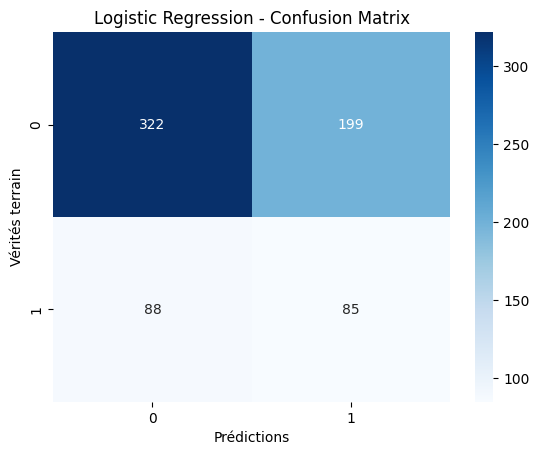

In [95]:
logreg = LogisticRegression(max_iter=1000, class_weight='balanced')
f1_logreg = train_evaluate(logreg, X_train_emb, y_train, X_test_emb, y_test, "Logistic Regression")


(b) Modèle SVM (Support Vector Classifier)


===== SVM =====
              precision    recall  f1-score   support

           0      0.783     0.618     0.691       521
           1      0.297     0.486     0.368       173

    accuracy                          0.585       694
   macro avg      0.540     0.552     0.530       694
weighted avg      0.662     0.585     0.611       694



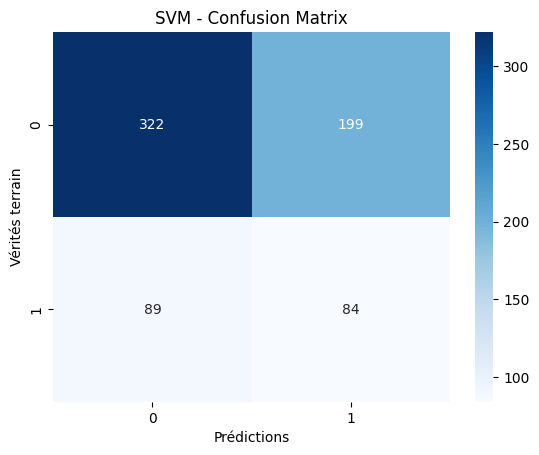

In [96]:
svm = LinearSVC( class_weight='balanced',  random_state=42)
f1_svm = train_evaluate(svm, X_train_emb, y_train, X_test_emb, y_test, "SVM")

(c) Modèle Random Forest


===== Random Forest =====
              precision    recall  f1-score   support

           0      0.750     0.998     0.857       521
           1      0.000     0.000     0.000       173

    accuracy                          0.749       694
   macro avg      0.375     0.499     0.428       694
weighted avg      0.563     0.749     0.643       694



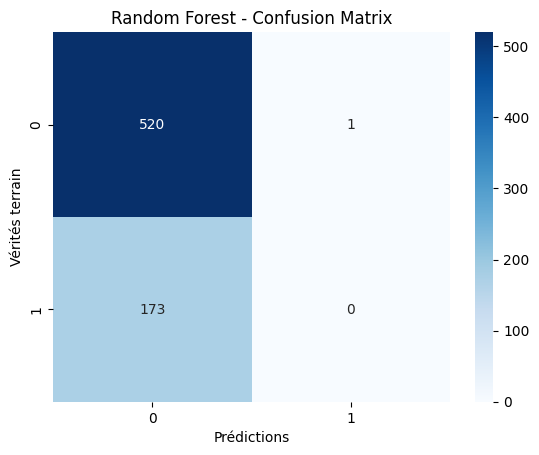

In [97]:

rf = RandomForestClassifier( class_weight='balanced', random_state=42)
f1_rf = train_evaluate(rf, X_train_emb, y_train, X_test_emb, y_test, "Random Forest")



(d) Modèle Naive Bayes (GaussianNB)


===== Naive Bayes (GaussianNB) =====
              precision    recall  f1-score   support

           0      0.776     0.747     0.761       521
           1      0.316     0.353     0.333       173

    accuracy                          0.648       694
   macro avg      0.546     0.550     0.547       694
weighted avg      0.662     0.648     0.655       694



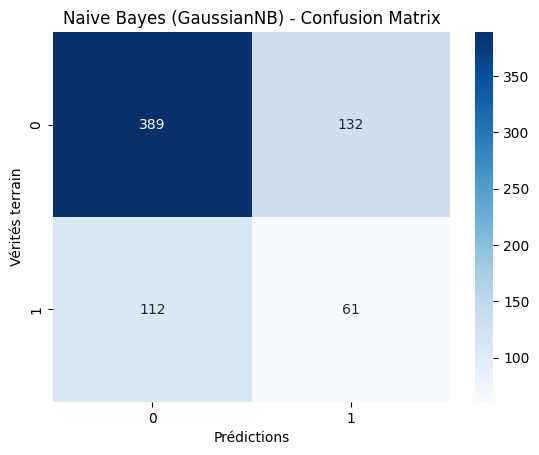

In [98]:
gnb = GaussianNB()
f1_gnb = train_evaluate(gnb, X_train_emb, y_train, X_test_emb, y_test, "Naive Bayes (GaussianNB)")

(e) Modèle K-Nearest Neighbors (KNN)


===== KNN =====


              precision    recall  f1-score   support

           0      0.754     0.919     0.829       521
           1      0.288     0.098     0.147       173

    accuracy                          0.715       694
   macro avg      0.521     0.509     0.488       694
weighted avg      0.638     0.715     0.659       694



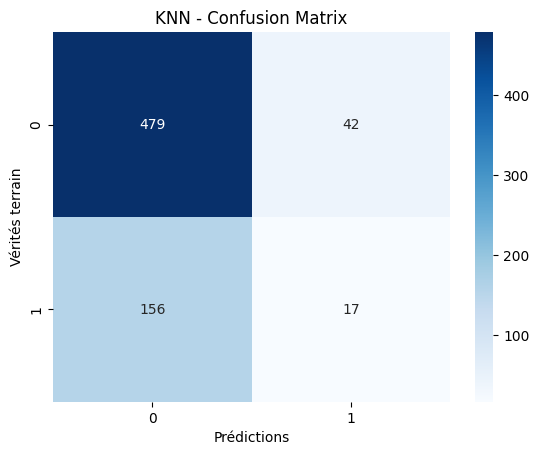

In [99]:
knn = KNeighborsClassifier(n_neighbors=5)  
f1_knn = train_evaluate(knn, X_train_emb, y_train, X_test_emb, y_test, "KNN")

(f) Modèle XGBoost


===== XGBoost =====


c:\Users\brahi\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [22:14:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0      0.757     0.914     0.828       521
           1      0.308     0.116     0.168       173

    accuracy                          0.715       694
   macro avg      0.532     0.515     0.498       694
weighted avg      0.645     0.715     0.663       694



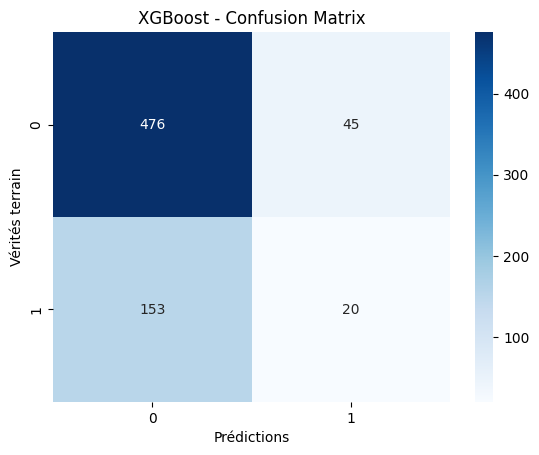

In [100]:

neg = sum([1 for label in y_train if label==0])
pos = sum([1 for label in y_train if label==1])
scale_pos_weight = neg / pos

xgb = xgb.XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
f1_xgb = train_evaluate(xgb, X_train_emb, y_train, X_test_emb, y_test, "XGBoost")


(g) Modèle LightGBM


===== LightGBM =====
[LightGBM] [Info] Number of positive: 694, number of negative: 2080
[LightGBM] [Info] Total Bins 97920
[LightGBM] [Info] Number of data points in the train set: 2774, number of used features: 384
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
              precision    recall  f1-score   support

           0      0.757     0.927     0.833       521
           1      0.321     0.104     0.157       173

    accuracy                          0.722       694
   macro avg      0.539     0.516     0.495       694
weighted avg      0.648     0.722     0.665       694



c:\Users\brahi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


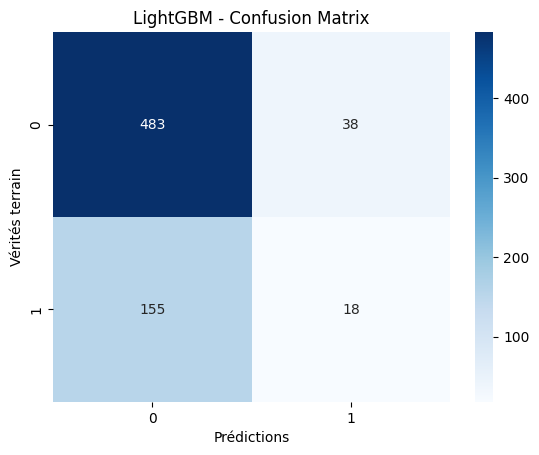

In [101]:

import lightgbm as lgb

lgb_model = lgb.LGBMClassifier(
    objective='binary',
    class_weight='balanced', 
    n_estimators=100,
    force_col_wise=True
)
f1_lgb = train_evaluate(lgb_model, X_train_emb, y_train, X_test_emb, y_test, "LightGBM")


(h) Modèle GradientBoost


===== Gradient Boosting =====
              precision    recall  f1-score   support

           0      0.749     0.944     0.835       521
           1      0.216     0.046     0.076       173

    accuracy                          0.720       694
   macro avg      0.483     0.495     0.456       694
weighted avg      0.616     0.720     0.646       694



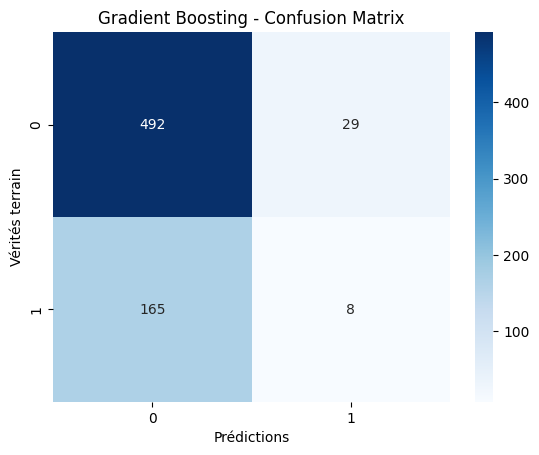

In [102]:

from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=42)
f1_gb = train_evaluate(gb, X_train_emb, y_train, X_test_emb, y_test, "Gradient Boosting")


***5-Comparaison et sélection du meilleur modèle***

1. Modèles utilisés et F1-score associés

In [103]:
model_preds= {"Logistic Regression": f1_logreg,
              "SVM": f1_svm,
              "Random Forest": f1_rf,
              "Naive Bayes": f1_gnb,
              "KNN": f1_knn,
              "XGBoost": f1_xgb,
              "LightGBM": f1_lgb,
              "Gradient Boosting": f1_gb
            }
models={"Logistic Regression": logreg,
            "SVM": svm,
        "Random Forest": rf,
        "Naive Bayes": gnb,
        "KNN": knn,
        "XGBoost": xgb,
        "LightGBM": lgb_model,
        "Gradient Boosting": gb
        }


2. Définition de la classe minoritaire

In [104]:
from collections import Counter

counter = Counter(y_train)
minority_class = min(counter, key=counter.get)
print("Classe minoritaire =", minority_class)


Classe minoritaire = 1


3. Calcul des métriques pour la classe minoritaire

In [105]:

results = []

for name in model_preds.keys():
    y_pred = model_preds[name]
    model = models[name]

    # F1 score par classe (array)
    f1_per_class = f1_score(y_test, y_pred, average=None)
    f1_minority  = f1_per_class[minority_class]  

    # Precision & Recall pour la classe minoritaire
    precision_per_class = precision_score(y_test, y_pred, average=None)
    recall_per_class    = recall_score(y_test, y_pred, average=None)

    precision_minority = precision_per_class[minority_class]
    recall_minority    = recall_per_class[minority_class]

    # AUC si possible
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test_emb)[:, 1]
        auc = roc_auc_score(y_test, y_proba)
    elif hasattr(model, "decision_function"):
        y_score = model.decision_function(X_test_emb)
        auc = roc_auc_score(y_test, y_score)
    else:
        auc = None

    results.append({
        "Model": name,
        "Precision_minority": precision_minority,
        "Recall_minority": recall_minority,
        "F1_minority": f1_minority,
        "AUC": auc
    })



c:\Users\brahi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


4. Présenter les résultats dans un tableau comparatif

In [106]:
df_results = pd.DataFrame(results)
df_results = df_results.sort_values(by="F1_minority", ascending=False)
df_results.reset_index(drop=True, inplace=True)
df_results


,Model,Precision_minority,Recall_minority,F1_minority,AUC
0,Logistic Regression,0.299296,0.491329,0.371991,0.567628
1,SVM,0.296820,0.485549,0.368421,0.554447
2,Naive Bayes,0.316062,0.352601,0.333333,0.560061
3,XGBoost,0.307692,0.115607,0.168067,0.514517
4,LightGBM,0.321429,0.104046,0.157205,0.516892
5,KNN,0.288136,0.098266,0.146552,0.538382
6,Gradient Boosting,0.216216,0.046243,0.076190,0.529362
7,Random Forest,0.000000,0.000000,0.000000,0.563922


5. Sélection du meilleur modèle selon le F1 de la classe minoritaire

In [107]:
best_model = df_results.loc[0, "Model"]
print(f"Best model based on F1 score for minority class: {best_model}")

Best model based on F1 score for minority class: Logistic Regression


***6-Test final et sauvegarde***

1. Chargement et aperçu du fichier de test

In [108]:
test_data = pd.read_csv('task_A_En_test.csv')
test_data.head()

,tweet,sarcastic
0,"Size on the the Toulouse team, That pack is mo...",0
1,Pinball!,0
2,So the Scottish Government want people to get ...,1
3,villainous pro tip : change the device name on...,0
4,I would date any of these men 🥺,0


2. Prétraitement des textes du fichier de test

In [109]:
test_data['text_cleaned'] = test_data['tweet'].apply(clean_text)
test_data.head()

,tweet,sarcastic,text_cleaned
0,"Size on the the Toulouse team, That pack is mo...",0,size toulouse team pack monstrous cant see wel...
1,Pinball!,0,pinball
2,So the Scottish Government want people to get ...,1,scottish government want people booster shots ...
3,villainous pro tip : change the device name on...,0,villainous pro tip change device name bluetoot...
4,I would date any of these men 🥺,0,date men


3. Encodage des textes du test avec SBERT

In [110]:
X_test_final_list = test_data['text_cleaned'].astype(str).tolist()
X_test_final_emb = model_sbert.encode(X_test_final_list, batch_size=32, show_progress_bar=True)



Batches: 100%|██████████| 44/44 [00:02<00:00, 17.36it/s]


4. Prédictions sur le fichier de test avec le meilleur modèle 

In [111]:
best_model_instance = models[best_model]
y_test_final_pred = best_model_instance.predict(X_test_final_emb)
test_data['sarcastic_pred'] = y_test_final_pred
test_data.head()

,tweet,sarcastic,text_cleaned,sarcastic_pred
0,"Size on the the Toulouse team, That pack is mo...",0,size toulouse team pack monstrous cant see wel...,1
1,Pinball!,0,pinball,0
2,So the Scottish Government want people to get ...,1,scottish government want people booster shots ...,0
3,villainous pro tip : change the device name on...,0,villainous pro tip change device name bluetoot...,1
4,I would date any of these men 🥺,0,date men,1


5. Évaluation des prédictions sur le fichier de test


Classification Report on Test Data:
              precision    recall  f1-score   support

           0      0.909     0.565     0.697      1200
           1      0.202     0.660     0.309       200

    accuracy                          0.579      1400
   macro avg      0.555     0.613     0.503      1400
weighted avg      0.808     0.579     0.641      1400

AUC : 0.648


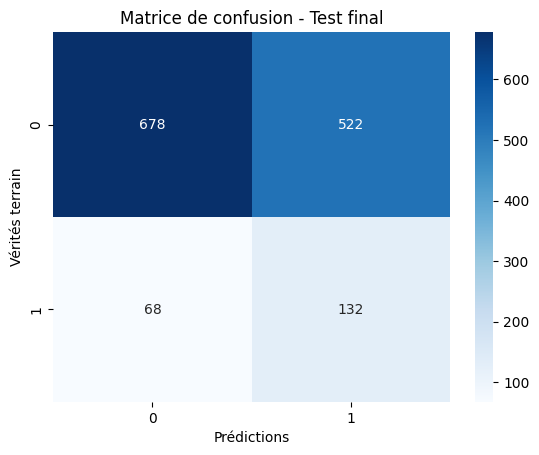

In [112]:
if 'sarcastic' in test_data.columns:
    y_true = test_data['sarcastic']
    y_pred = test_data['sarcastic_pred']
    print("\nClassification Report on Test Data:")
    print(classification_report(y_true, y_pred, digits=3))
    try:
        y_prob = best_model_instance.predict_proba(X_test_final_emb)[:, 1]
        auc = roc_auc_score(y_true, y_prob)
        print(f"AUC : {auc:.3f}")
    except:
        print("AUC non disponible (le modèle ne supporte pas predict_proba).")
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Matrice de confusion - Test final")
    plt.xlabel("Prédictions")
    plt.ylabel("Vérités terrain")
    plt.show()
else:
    print("⚠️ La colonne 'sarcastic' n'existe pas dans le fichier test.")



6. Sauvegarde du modèle et des prédictions finales avec les labels

In [113]:

joblib.dump(best_model_instance, "best_model_sbert.pkl")

test_data[["text_cleaned","sarcastic_pred","sarcastic"]].to_csv("final_predictions.csv", index=False)

print("✔ Modèle sauvegardé : best_model_sbert.pkl")
print("✔ Prédictions sauvegardées : final_predictions.csv")


✔ Modèle sauvegardé : best_model_sbert.pkl
✔ Prédictions sauvegardées : final_predictions.csv
